In [1]:
!pwd

/content


In [2]:
from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pwd

/content


In [4]:
cd "drive/MyDrive/Doutorado/Disciplinas/[2022.1] [UFF] Processamento de Linguagem Natural - Professora: Aline Marins Paes Carvalho/Trabalhos/Trabalho 2 - POS  e Transfer Learning/"

/content/drive/MyDrive/Doutorado/Disciplinas/[2022.1] [UFF] Processamento de Linguagem Natural - Professora: Aline Marins Paes Carvalho/Trabalhos/Trabalho 2 - POS  e Transfer Learning


In [5]:
!pwd

/content/drive/MyDrive/Doutorado/Disciplinas/[2022.1] [UFF] Processamento de Linguagem Natural - Professora: Aline Marins Paes Carvalho/Trabalhos/Trabalho 2 - POS  e Transfer Learning


# Imports

In [6]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip3 install pyconll
import pyconll # https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Classificação de Tokens (muito-para-muitos)

Vamos agora refinar o modelo BERTimbau para uma tarefa de classificação de tokens.

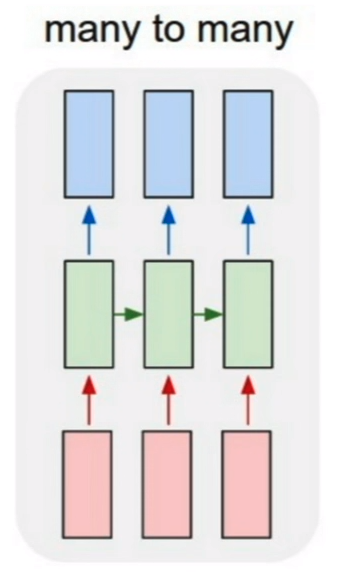

Carregando e formatando o dataset em português.

In [8]:
# Baseado em https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb

# trainset
train_X = list()
train_y = list()
data = pyconll.load_from_file( './datasets/pt_bosque-ud-train.conllu' )
train_tagged_sentences=[]
t=0
for sentence in data:
    tagged_sentence=[]
    X_sentence = list()
    y_sentence = list()
    for token in sentence:
        if token.upos and token.form:
            t+=1
            tagged_sentence.append((token.form.lower(), token.upos))

            X_sentence.append( token.form )
            y_sentence.append( token.upos )
    train_X.append( ' '.join(str(t) for t in X_sentence) )
    train_y.append( [str(tag) for tag in y_sentence] )
    train_tagged_sentences.append(tagged_sentence)

# devset

dev_X = list()
dev_y = list()
data = pyconll.load_from_file( './datasets/pt_bosque-ud-dev.conllu' )
dev_tagged_sentences=[]
t=0
for sentence in data:
    tagged_sentence=[]
    X_sentence = list()
    y_sentence = list()
    for token in sentence:
        if token.upos and token.form:
            t+=1
            tagged_sentence.append((token.form.lower(), token.upos))

            X_sentence.append( token.form )
            y_sentence.append( token.upos )
    dev_X.append( ' '.join(str(t) for t in X_sentence) )
    dev_y.append( [str(tag) for tag in y_sentence] )
    dev_tagged_sentences.append(tagged_sentence)


In [9]:
def parse(data):
  X = [' '.join([w[0] for w in snt]) for snt in data]
  y = [[w[1] for w in snt] for snt in data]

  tags = []
  for snt in y:
    tags.extend(snt)
  tags = list(set(tags))
  tags.append('<pad>')
  tag2id = { tag:i for i, tag in enumerate(tags) }
  id2tag = { i:tag for i, tag in enumerate(tags) }
  return X, y, tag2id, id2tag

train_X, train_y, tag2id, id2tag = parse( train_tagged_sentences )
dev_X, dev_y, _, _ = parse( dev_tagged_sentences )

Como o tokenizador do BERTimbau pode segmentar o texto em sub-tokens, precisamos alinhá-los as tags que marcam as classes gramaticais

In [10]:
# align
from transformers import AutoTokenizer

def align(X, y):
  tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
  
  procdata = []
  for (X_, y_) in zip(X, y):
    inputs = tokenizer(X_, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    try:
      new_tags = ['<pad>']
      pos = 0
      for token in tokens[1:-1]:
        if '##' in token:
          new_tags.append(y_[pos-1])
        else:
          new_tags.append(y_[pos])
          pos += 1
      new_tags.append('<pad>')

      procdata.append({ 'X': X_, 'y': ' '.join(new_tags) })
    except:
      pass
  return procdata

trainset = align(train_X, train_y)
devset = align(dev_X, dev_y)

len(trainset), len(devset)

(5496, 913)

Importando dependências. Veja que utilizaremos os métodos `AutoTokenizer` e `AutoModelForTokenClassification` para instanciar o tokenizador e o modelo de classificação de tokens.

In [11]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

Definindo parâmetros do modelo e treinamento

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = len(tag2id)
nepochs = 10
batch_size = 16
batch_status = 32
learning_rate = 1e-5

early_stop = 2
max_length = 180
write_path = 'model'

Separando os dados em batches

In [13]:
from torch.utils.data import DataLoader

traindata = DataLoader(trainset, batch_size=batch_size, shuffle=True)
devdata = DataLoader(devset, batch_size=batch_size, shuffle=True)

Inicializando tokenizador, modelo, função de erro e otimizador

In [14]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
model = AutoModelForTokenClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Método de Avaliação

In [15]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts = inp['X']

    labels = []
    for tags in inp['y']:
      tag_idxs = [tag2id[tag] for tag in tags.split()]
      labels.append(tag_idxs)
    
    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 2).tolist()

    for i in range(len(labels)):
      y_real.extend(labels[i][1:-1])
      seq_size = len(labels[i][1:-1])
      y_pred.extend(pred_labels[i][1:seq_size+1])
    
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [16]:
from torch.nn.utils.rnn import pad_sequence

max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts = inp['X']
    
    labels = []
    for tags in inp['y']:
      tag_idxs = [tag2id[tag] for tag in tags.split()]
      labels.append(torch.tensor(tag_idxs[:max_length]))
    
    labels= pad_sequence(labels, padding_value=tag2id['<pad>']).transpose(0, 1).unsqueeze(0).contiguous()

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  f1, acc = evaluate(model, devdata)
  # print('F1: ', f1, 'Accuracy: ', acc)
  print( f'F1: {f1:.2}' )
  print( f'Accuracy: {acc:.2}' )
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  if repeat == early_stop:
    break

Train Epoch: 0 [32/344 (9%)]	Loss: 1.577737	Total Loss: 2.148000
Train Epoch: 0 [64/344 (18%)]	Loss: 1.197158	Total Loss: 1.665040
Train Epoch: 0 [96/344 (28%)]	Loss: 0.509132	Total Loss: 1.352610
Train Epoch: 0 [128/344 (37%)]	Loss: 0.356048	Total Loss: 1.118310
Train Epoch: 0 [160/344 (46%)]	Loss: 0.263001	Total Loss: 0.953690
Train Epoch: 0 [192/344 (56%)]	Loss: 0.215110	Total Loss: 0.832030
Train Epoch: 0 [224/344 (65%)]	Loss: 0.205910	Total Loss: 0.737380
Train Epoch: 0 [256/344 (74%)]	Loss: 0.112080	Total Loss: 0.663980
Train Epoch: 0 [288/344 (83%)]	Loss: 0.073916	Total Loss: 0.604430
Train Epoch: 0 [320/344 (93%)]	Loss: 0.076411	Total Loss: 0.554750
Progress: 0.53 31


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4637
           1       0.88      0.90      0.89      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       0.00      0.00      0.00        11
           6       0.89      0.88      0.88       515
           7       0.94      0.95      0.94       760
           8       0.98      0.99      0.98      3082
           9       0.00      0.00      0.00        46
          10       0.96      0.87      0.92      3122
          11       0.90      0.93      0.91       838
          12       0.95      0.91      0.93       348
          13       0.00      0.00      0.00         4
          14       0.98      0.98      0.98      2889
          15       0.95      0.98      0.96      2700
          16       0.93      0.92      0.93       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4637
           1       0.92      0.89      0.90      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       1.00      0.18      0.31        11
           6       0.92      0.92      0.92       515
           7       0.95      0.98      0.97       760
           8       0.99      0.99      0.99      3082
           9       0.00      0.00      0.00        46
          10       0.93      0.94      0.94      3122
          11       0.93      0.95      0.94       838
          12       0.96      0.94      0.95       348
          13       0.00      0.00      0.00         4
          14       0.99      0.98      0.99      2889
          15       0.96      0.98      0.97      2700
          16       0.93      0.98      0.96       503

    accuracy                           0.96     23948
   macro avg       0.84   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4637
           1       0.91      0.91      0.91      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       1.00      1.00      1.00        11
           6       0.95      0.92      0.94       515
           7       0.96      0.99      0.97       760
           8       0.99      0.99      0.99      3082
           9       0.00      0.00      0.00        46
          10       0.94      0.94      0.94      3122
          11       0.94      0.96      0.95       838
          12       0.98      0.95      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.97      0.98      0.97      2700
          16       0.93      0.99      0.96       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4637
           1       0.92      0.90      0.91      1352
           2       1.00      1.00      1.00      2671
           3       0.99      1.00      0.99       470
           5       1.00      1.00      1.00        11
           6       0.96      0.94      0.95       515
           7       0.96      0.99      0.97       760
           8       0.99      0.99      0.99      3082
           9       0.71      0.54      0.62        46
          10       0.94      0.94      0.94      3122
          11       0.94      0.96      0.95       838
          12       0.99      0.95      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.97      0.98      0.98      2700
          16       0.96      0.99      0.97       503

    accuracy                           0.97     23948
   macro avg       0.89   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4637
           1       0.93      0.90      0.91      1352
           2       1.00      1.00      1.00      2671
           3       1.00      0.99      1.00       470
           5       1.00      1.00      1.00        11
           6       0.95      0.95      0.95       515
           7       0.97      0.99      0.98       760
           8       0.99      0.99      0.99      3082
           9       0.73      0.52      0.61        46
          10       0.94      0.94      0.94      3122
          11       0.96      0.95      0.95       838
          12       0.99      0.94      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.97      0.99      0.98      2700
          16       0.97      0.98      0.97       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4637
           1       0.91      0.93      0.92      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       1.00      1.00      1.00        11
           6       0.95      0.95      0.95       515
           7       0.97      0.99      0.98       760
           8       0.99      0.99      0.99      3082
           9       0.41      0.67      0.51        46
          10       0.96      0.92      0.94      3122
          11       0.96      0.95      0.96       838
          12       0.99      0.94      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.98      0.98      0.98      2700
          16       0.96      0.98      0.97       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4637
           1       0.93      0.91      0.92      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       1.00      1.00      1.00        11
           6       0.95      0.95      0.95       515
           7       0.97      0.99      0.98       760
           8       0.99      0.99      0.99      3082
           9       0.64      0.65      0.65        46
          10       0.95      0.94      0.94      3122
          11       0.97      0.95      0.96       838
          12       0.99      0.94      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.97      0.99      0.98      2700
          16       0.98      0.97      0.97       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4637
           1       0.93      0.91      0.92      1352
           2       1.00      1.00      1.00      2671
           3       0.99      0.99      0.99       470
           5       1.00      1.00      1.00        11
           6       0.96      0.94      0.95       515
           7       0.97      0.99      0.98       760
           8       0.99      0.99      0.99      3082
           9       0.81      0.63      0.71        46
          10       0.95      0.94      0.95      3122
          11       0.96      0.95      0.96       838
          12       0.99      0.94      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      0.99      0.99      2889
          15       0.97      0.99      0.98      2700
          16       0.97      0.97      0.97       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4637
           1       0.92      0.92      0.92      1352
           2       1.00      1.00      1.00      2671
           3       1.00      0.99      0.99       470
           5       1.00      1.00      1.00        11
           6       0.96      0.94      0.95       515
           7       0.97      0.98      0.98       760
           8       0.99      1.00      0.99      3082
           9       0.70      0.61      0.65        46
          10       0.95      0.94      0.95      3122
          11       0.96      0.95      0.96       838
          12       0.99      0.93      0.96       348
          13       0.00      0.00      0.00         4
          14       0.99      1.00      0.99      2889
          15       0.97      0.99      0.98      2700
          16       0.97      0.97      0.97       503
          17       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1